# Disability at six months (results)

In this notebook, we explore disability at 6 months and the change in disability between discharge and six months.

## Context about measurement of disability

Disability is measured using the modified Rankin Scale (mRS). The scale ranges from 0 to 6, where 0 is perfect health without symptoms and 6 is death. The dataset contains information on:
* Disability before the stroke
* Disability at discharge
* Disability at six months

## Aims

* Investigate disability at six months
* Investigate the change in disability between discharge and six months

## Purpose of this analysis

In other analyses, we are using discharge disability. One reason for that is because six month disability is so incomplete.

However, understanding the relationship between discharge disability and six month disability is useful context, if you were to start thinking about more long-term outcomes. There should be alot of sceptism around this analysis, however, as we believe that data on six month disability is not missing at random.

## Caveats

Caveats of this data and analysis include...

**Follow-up is not missing at random.** Lots of patients are missing data on disability at six months, and this information is not missing at random. We know that the likelihood of having a follow-up assessment may be influenced by several different factors. We know that disability (including death) at six months is input manually (and so, case ascertainment is not more reliable for those died, but will vary between providers, as with the input of all mRS scores at 6 months). There are some SSNAP reports on their website where they link to mortality data from ONS once per year to report on mortality, but we do not have access to that.

**Variation in follow up date.** SSNAP data is provided for patients with a "follow-up assessment at six months post admission (plus or minus two months). This means that the data can actually be from 4 to 8 months after admission, which is a large amount of variability. It is possible that this variation may not be random (and that certain patients are more or less likely to be followed up earlier or later).

**Variation in discharge date.** SSNAP data on disability after stroke is provided for the point of discharge, but different patients will have different lengths of stay (likely influenced by patient/clinical characteristics). This means we are comparing disability that could be at very different lengths of time after the stroke.

**Disability is ordinal.** Disability is measured using mRS which is an ordinal scale - i.e. the categories have an order but there is not a consistent space between each score on the scale. This is one reason why some other analyses are focussing on utility, and we know the difference in utility for mRS 0 to mRS 3 is the difference between mRS 4 and 5, which indicates that a change from 4 to 5 reflects a greater change in health related quality of life than 0 to 1, and potentially a greater functional change.

**Confounders:** Change in disability could be due to factors besides stroke - such as other conditions not captured here.

## Summary

* **Mean disability:** Mean 6-month disability 2.18 (n=109,321) and mean discharge disability 2.65 (n=356,355) - two different samples
* **Distribution of change in disability:** Focussing on patients with discharge and 6-month disability, we most frequently see no change in disability (31.5%), then a change of one mRS score (apx. 40%), then two mRS (apx. 18%), three mRS (apx. 6%), and then very few with a change of four mRS or more
* **Factors associated with six month disability:** Using descriptive analysis, we see worse disability at six months for patients with greater prior or discharge disability, greater stroke severity, and older age. There is little difference between thrombolysed and non-thrombolysed patients.
* **Factors associated with change in disability:**
    * Using descriptive analysis, looking at change in disability from discharge to six months, we see patterns that match with the prior analysis, but with the addition of impacts from scale used - i.e. patient with discharge disability of 0 has no scope to improve, and patient with discharge disability of 5 cannot worsen by more than 1, and so on. Looking at the proportion who stay the same, worsen or improve, the majority of patients with a discharge disability of 2, 3 or 4 are better at six months, and the majority with a score of 0 or 5 are worse.
    * Multiple linear regression finds discharge disability and thrombolysis are associated with improving disability from discharge, whilst prior disability, stroke severity and age are associated with decline. However, as above, some of this is artefacts of scale - if you have a higher discharge disability, you have more scope to improve.

## Set up

In [1]:
# Import packages and functions
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, confusion_matrix)

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Reformat dataset

In [4]:
# Restrict to individuals not dead at discharge
data_full_alive = data_full[data_full['death'] == 0].copy()

# Create stroke severity column with groups so can plot in same way as others
conditions = [(data_full_alive['stroke_severity'] == 0),
              (data_full_alive['stroke_severity'].isin(np.arange(1, 5))),
              (data_full_alive['stroke_severity'].isin(np.arange(5, 16))),
              (data_full_alive['stroke_severity'].isin(np.arange(16, 21))),
              (data_full_alive['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['0', '1-4', '5-15', '16-20', '21-42']
data_full_alive['stroke_severity_groups'] = np.select(conditions,
                                                      nihss_choices)

# Create column with change in disability from discharge to 6 months
data_full_alive['discharge_to_6_month'] = (
    data_full_alive['disability_6_month'] -
    data_full_alive['discharge_disability'])

# Restrict to individuals with 6 month disability
data_full_alive_change = data_full_alive[
    ~data_full_alive['disability_6_month'].isnull()]

## Disability at six months (and change from discharge)

In [5]:
# Describe average disability at each timepoint
pd.concat([data_full['discharge_disability'].describe(),
           data_full['disability_6_month'].describe()], axis=1)

,discharge_disability,disability_6_month
count,356355.000000,109321.000000
mean,2.649933,2.176947
std,1.919072,1.807213
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,4.000000,3.000000
max,6.000000,6.000000


Observations: There are 109,321 patients with data on six month disability, with a mean mRS score of 2.18 and median score of 2. This is lower than the average disability of the 356,355 patients with discharge disability recorded, which was a mean of 2.65.

,discharge_disability,disability_6_month
0.0,0.130185,0.164580
1.0,0.212566,0.288078
2.0,0.183115,0.189781
3.0,0.161376,0.156841
4.0,0.116603,0.070654
5.0,0.056334,0.024231
6.0,0.139821,0.105835


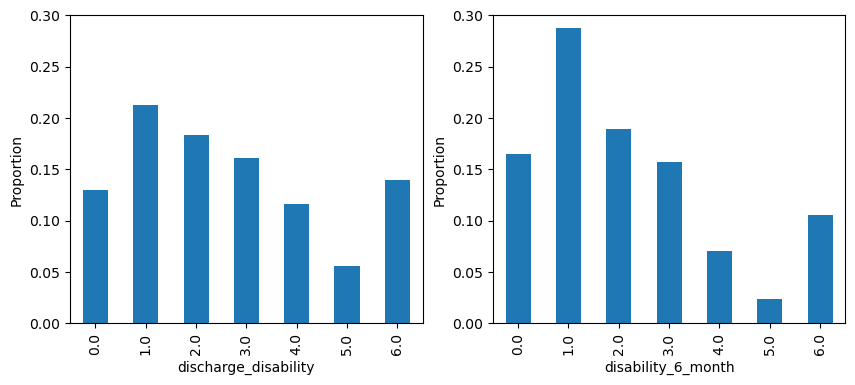

In [6]:
def describe_disability(timepoint, ax):
    '''
    For the specified timepoint, describe the proportion of people
    with each disability score and present in a plot
    timepoint: string e.g. discharge_disability
    ax: axes object to create plot on
    '''
    # Find and display proportion of people with each score
    mrs_6m = (data_full[timepoint]
              .value_counts(normalize=True)
              .sort_index())

    # Create plot
    mrs_6m.plot(kind='bar', ax=ax)
    ax.set_xlabel(timepoint)
    ax.set_ylabel('Proportion')
    ax.set_ylim([0, 0.3])

    # Return results
    return mrs_6m


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
mrs_discharge = describe_disability('discharge_disability', ax[0])
mrs_6months = describe_disability('disability_6_month', ax[1])
display(pd.concat([mrs_discharge, mrs_6months], axis=1))
plt.show()

**Remember!** These are two different samples.

Observations: A greater proportion of patients at six months have lower mRS scores - e.g. 28.8% mRS 1 at six months, versus 21.2% at discharge. Conversely, a lower proportion of patients at six months have higher mRS scores - e.g. 10.6% mRS 6 at six months, versus 14.0% at discharge.

count    109321.00000
mean          0.11533
std           1.52376
min          -5.00000
25%          -1.00000
50%           0.00000
75%           1.00000
max           6.00000
Name: discharge_to_6_month, dtype: float64


-5.0    0.000201
-4.0    0.003183
-3.0    0.024177
-2.0    0.092041
-1.0    0.218979
 0.0    0.315283
 1.0    0.196248
 2.0    0.086635
 3.0    0.035849
 4.0    0.013803
 5.0    0.009230
 6.0    0.004372
Name: discharge_to_6_month, dtype: float64

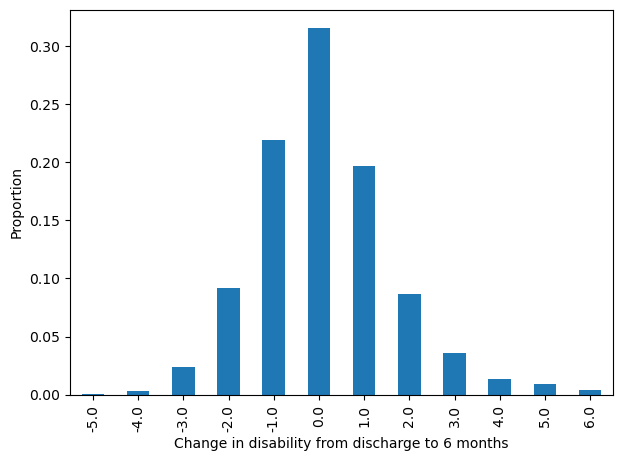

In [7]:
# Calculate change in disability
mrs_change = data_full_alive_change['discharge_to_6_month']

# Describe average change
print(mrs_change.describe())

# Find proportion with each change
mrs_change_prop = mrs_change.value_counts(normalize=True).sort_index()
display(mrs_change_prop)

# Visualise distribution of changes
fig, ax = plt.subplots(figsize=(7, 5))
mrs_change_prop.plot(kind='bar', ax=ax)
ax.set_xlabel('Change in disability from discharge to 6 months')
ax.set_ylabel('Proportion')
plt.show()

**Remember!** This is just the sample of people with disability recorded at 6 months.

Observations: We see a mean change of 0.1 (worsening). Looking at the distribution of results - 
* **Most frequently see no change** in disability (31.5%)
* **Looking at one or two mRS change, we see more people getting better**. One mRS better for 21.9% and one mRS worse for 19.6%. Two mRS better for 9.2% and two mRS worse for 8.7%
* **Looking at a change of 3 mRS or more, we see more people getting worse**. Three mRS better for 2.4% and three mRS worse for 3.6%. Very few of a change of four mRS or more. There are very few patients with four mRS (0.3%) or five mRS (0.02%) better. There are slightly more with worsening mRS - four mRS (0.1%), five mRS (0.09%) or six mRS (0.04%) worse

## Factors associated with disability at six months

In [8]:
def boxplot_6_month(variable, outcome, ax, positions=False, xfontsize=10):
    '''
    Create box plot of the distribution of
    disability at 6 months, grouped by the specified variable
    Inputs:
    variable - string, variable to group by
    outcome - string, disability outcome to plot
    ax - axis object to plot on
    positions - array defining order for x axis (default False)
    xfontsize - integer, fontsize for x tick labels (default 10)
    '''
    # Extract values by group
    values = (data_full_alive_change
              .groupby(variable)[outcome]
              .apply(list))

    # Create box plot, ordered by positions if provided
    if positions:
        ax.boxplot(values, positions=positions)
    else:
        ax.boxplot(values)

    # Add appropriate labels
    ax.set_xlabel(variable)
    ax.set_xticklabels(values.index, fontsize=xfontsize)
    ax.set_ylabel(outcome)

In [9]:
def stacked_bar_6_month(variable, outcome, ax, order=False):
    '''
    Creates stacked bar of disability at 6 months, when patients are
    grouped by the specified variable
    Inputs:
    variable - string, e.g. 'prior_disability'
    outcome - string, disability outcome to plot
    ax - axis object to plot on
    order - array defining order for x axis (default False)
    '''
    df = (data_full_alive_change
          .groupby(variable)[outcome]
          .value_counts(normalize=True)
          .reset_index(name='prop')
          .pivot(columns=outcome,
                 index=variable,
                 values='prop'))
    if order:
        df.loc[order].plot(kind='bar', stacked=True, ax=ax)
    else:
        df.plot(kind='bar', stacked=True, ax=ax)
    ax.set_ylabel('Proportion')
    ax.get_legend().remove()

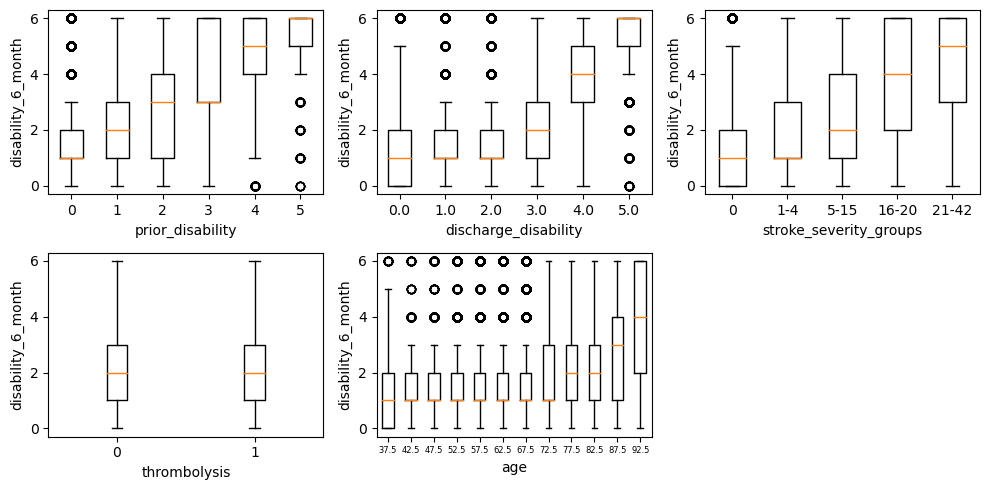

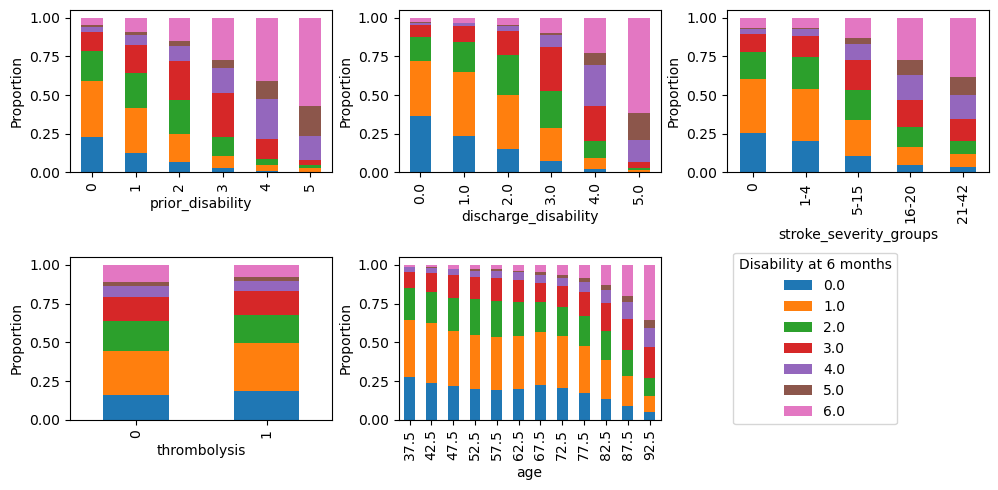

In [10]:
# Create box plots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
boxplot_6_month('prior_disability', 'disability_6_month', ax[0, 0])
boxplot_6_month('discharge_disability', 'disability_6_month', ax[0, 1])
boxplot_6_month('stroke_severity_groups', 'disability_6_month', ax[0, 2],
                positions=[0, 1, 3, 4, 2])
boxplot_6_month('thrombolysis', 'disability_6_month', ax[1, 0])
boxplot_6_month('age', 'disability_6_month', ax[1, 1], xfontsize=6)

# Remove empty axis, resize and show
ax[1, 2].axis('off')
plt.tight_layout()
plt.show()

# Create stacked bar charts
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
stacked_bar_6_month('prior_disability', 'disability_6_month', ax[0, 0])
stacked_bar_6_month('discharge_disability', 'disability_6_month', ax[0, 1])
stacked_bar_6_month('stroke_severity_groups', 'disability_6_month', ax[0, 2],
                    order=nihss_choices)
stacked_bar_6_month('thrombolysis', 'disability_6_month', ax[1, 0])
stacked_bar_6_month('age', 'disability_6_month', ax[1, 1])

# Resize plots and add back in a legend
ax[1, 2].axis('off')
plt.tight_layout()
ax[1, 1].legend(loc='center left', bbox_to_anchor=(1.25, 0.5),
                title='Disability at 6 months')
plt.show()

**Observations:**

* **Prior disability and discharge disability** - on average, patients with greater prior or discharge disability have greater disability at six months, and vice versa. The majority of patients with a prior or discharge disability of 5 having died at six months.
* **Stroke severity** - patients with a higher stroke severity typically have a worse six month disability, and likewise a greater proportion have worse disability scores
* **Thrombolysis** - on average, a slightly higher proportion of thrombolysed patients have a six month disability score of 0 - but we see little difference when only grouping by whether thrombolysed or not
* **Age** - patients with older ages typically have a worse six month disability 

## Factors associated with change in disability

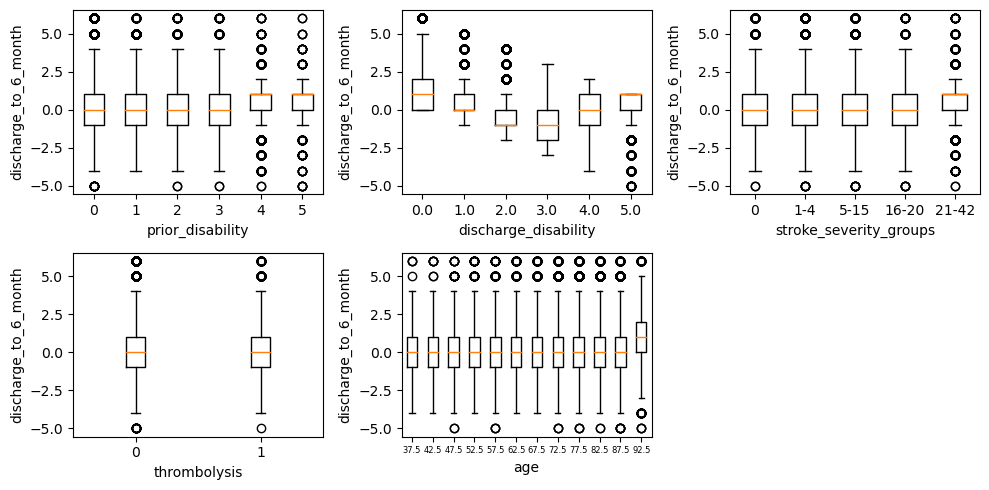

In [11]:
# Create box plots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
boxplot_6_month('prior_disability', 'discharge_to_6_month', ax[0, 0])
boxplot_6_month('discharge_disability', 'discharge_to_6_month', ax[0, 1])
boxplot_6_month('stroke_severity_groups', 'discharge_to_6_month', ax[0, 2],
                positions=[0, 1, 3, 4, 2])
boxplot_6_month('thrombolysis', 'discharge_to_6_month', ax[1, 0])
boxplot_6_month('age', 'discharge_to_6_month', ax[1, 1], xfontsize=6)

# Remove empty axis, resize and show
ax[1, 2].axis('off')
plt.tight_layout()
plt.show()

**Observations:** We see anticipated patterns, given the results when looking at disability at six months. However, we also see some results that reflect the scales used - for example:
* Patients with a discharge disability of 0 on average worsen with no results where a score improve (but that is because they have no scope to improve as they were at 0 already) Similar patterns to above, but with outcome of change in disability.
* Likewise, patients with a discharge disability of 5 cannot improve by more than 1. Patients with a discharge disability of 4 cannot improve by more than 2. And so on.

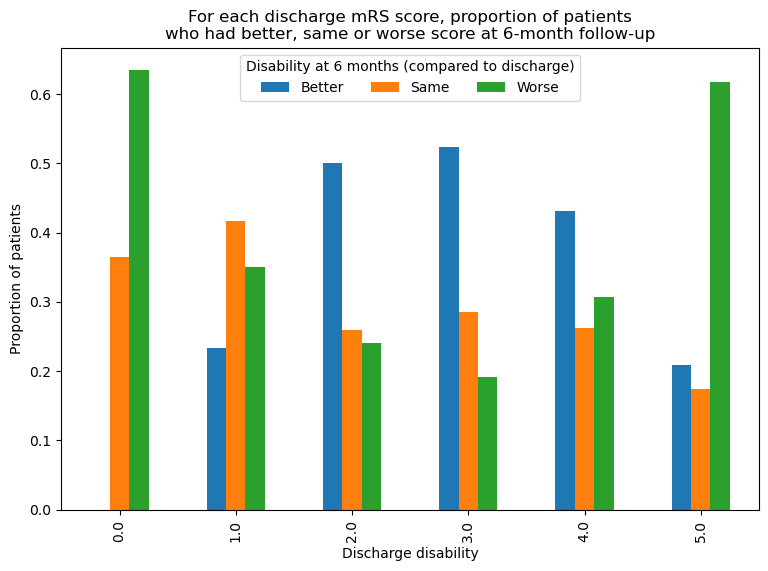

In [12]:
def plot_disability_change(df):
    '''
    For groups of patients with each discharge disability score, create a
    plot visualising the proportion whose scores were the same, better or
    worse at six months
    Inputs
    df: dataframe containing disability at discharge and six months
    '''
    # Extract individuals with complete data at followup
    mrs_compare = (df[['disability_6_month', 'discharge_disability']]
                   .dropna()
                   .rename(columns={'disability_6_month': 'followup',
                                    'discharge_disability': 'discharge'}))

    # Compare 6 month disability to discharge disability
    mrs_compare['compare'] = np.where(
        mrs_compare['followup'] > mrs_compare['discharge'], 'Worse',
        np.where(mrs_compare['followup'] < mrs_compare['discharge'],
                 'Better', 'Same'))

    # Find proportion better, same or worse - by discharge disability
    mrs_compare_3 = (
        mrs_compare.groupby('discharge')['compare']
        .value_counts(normalize=True, dropna=True)
        .reset_index(name='prop')
        .sort_values(by=['discharge', 'compare'])
        .pivot(index='discharge',
               columns='compare',
               values='prop')
        .fillna(0))

    # Plot these results
    fig, ax = plt.subplots(figsize=(9, 6))
    mrs_compare_3.plot.bar(ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion of patients')
    ax.legend(title='Disability at 6 months (compared to discharge)',
              loc='upper center', ncol=3)
    ax.set_title('For each discharge mRS score, proportion of patients' +
                 '\nwho had better, same or worse score at 6-month follow-up')
    plt.show()


plot_disability_change(data_full_alive)

This graph is another look at the associations between discharge disability and disability at 6 months.

**Observations:**
* Majority of patients with discharge score of 0 or 5 are worse
* Majority of patients with discharge score of 2, 3, or 4 are better

## Multiple linear regression

### Dataset

The dataset is patients who have complete data at each disability timepoint, as well as for stroke severity, age and whether thrombolysed.

In this model, we are predicting change in disability from discharge to six month follow up.

In [13]:
# Extract relevant columns and drop rows with NA
reg_df = data_full[['prior_disability', 'stroke_severity', 'age',
                    'thrombolysis', 'discharge_disability',
                    'disability_6_month']].dropna().reset_index()
display(reg_df.shape)

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['disability_6_month'] - reg_df['discharge_disability']

(109321, 7)

### Transform data, fit model, and collect evaluation metrics

In [14]:
def standardise_data(X_train, X_test):
    '''
    Put features on a similar scale through standardisation.
    Just transforms features (not response/target variable).
    Invovles subtracting mean and dividing by standard deviation (SD)
    of each feature, so data have mean of 0 and SD of 1.
    Test data is standardised on training data mean and SD.
    '''

    # Set up scaling object and fit on training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Apply scaling to training and test data
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

In [15]:
def run_regression(standardise):
    '''
    Run regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns MAE, MSE, RMSE, R2, adjusted R2, feature weights and residuals
    standardise: True or False
    '''
    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Predict y values using the x test values
        y_test_pred = model.predict(X_test)

        # Find residuals (difference between prediction and actual)
        resid = pd.DataFrame({'actual': y_test,
                              'pred': y_test_pred})
        resid['residuals'] = abs(resid['actual']) - abs(resid['pred'])
        reg_results['residuals'].append(resid)

        # Use predictions to calculate evaluation metrics
        reg_results['mae'].append(mean_absolute_error(y_test, y_test_pred))
        mse = mean_squared_error(y_test, y_test_pred)
        reg_results['mse'].append(mse)
        reg_results['rmse'].append(np.sqrt(mse))
        reg_results['r2'].append(r2_score(y_test, y_test_pred))
        adjusted_r2 = (1 -
                       (1 - model.score(X_train, y_train)) *
                       (len(y_train)-1) /
                       (len(y_train)-X_train.shape[1]-1))
        reg_results['adjusted_r2'].append(adjusted_r2)

    return (reg_results)

In [16]:
# Run with X variables standardised
reg_results = run_regression(standardise=True)

# Run without standardisation
reg_results_non_std = run_regression(standardise=False)

### Review results

In [17]:
def show_regression_results(results):
    '''
    Summarise results from regression, based on results dictionary input
    '''
    # Table of coefficients (as is, and absolute)
    coef = pd.DataFrame(results['feature_weights'], columns=X.columns)
    mean_coef = pd.DataFrame({'coef': coef.mean(),
                              'coef_abs': abs(coef.mean())})
    mean_coef_sort = mean_coef.sort_values(by='coef_abs', ascending=False)
    display(mean_coef_sort)

    # Plot of feature weights
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(mean_coef_sort.index, mean_coef_sort['coef'])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.show()

    # Metrics
    print(f'''
          Average MAE: {np.mean(results['mae']):.9f}
          Average RMSE: {np.mean(results['rmse']):.9f}
          Average R-squared: {np.mean(results['r2']):.9f}
          Average adjusted R-squared: {np.mean(results['adjusted_r2']):.9f}''')

#### Standardised results

**Understanding outcome score**

Outcome is change in disability score between discharge and six-month follow-up (disability_6_month - discharge_disability). **A negative result means that score improved.** A positive result means that the score worsened.

*Example: Patient sees improvement. They have mRS 3 at discharge and mRS 2 at 6-month. Their outcome would be negative, as score has gone down (2 - 3 = -1).*

**Interpreting the coefficients**

These are standardised - they are in units of standard deviation - and hence you can compare the relative importance of each variable, as they are on the same scale. Standardised coefficients reflect the change in outcome (in terms of standard deviation) for every increase of one standard deviation in the predictor.

* **Discharge disability** and **thrombolysis** have negative coefficients. This means that having a higher discharge disability, and receiving thrombolysis, are associated with an **improvement** in disability between discharge and follow-up (a negative change in score).
* **Prior disability**, **stroke severity** and **age** have positive coefficients. This means that having a higher prior disability, higher stroke severity, and older age, are associated with a **worsening** in disability between discharge and follow-up (a positive change in score).
* Discharge disability largest, so greatest relative importance.

**Note:** If you have a higher discharge disability, you have **more scope to improve** (e.g. mRS 5 can go down to mRS 1, but mRS 1 can change by a max of 1 to mRS 0). Hence, it is essentially an artefact of the scale and the scope to change. This analysis may therefore feel unhelpful - but should consider that it is still helpful in thinking through what is going on in the data.

**Note:** Confounding between discharge disability and stroke severity, as stroke severity can impact/associate with disability at disability and six months - would need to be careful when teasing apart relationship.

**Interpreting the metrics**
* **MAE**: Mean absolute error. Calculation is to find average of the residuals (which themselves are the difference between actual and predicted values). Lower value implies higher accuracy. Difficult to interpret as generally about comparing accuracy between models and depends on scale in dataset.
* **RMSE**: Square root of variance of residuals. Average distance between predicted and observed values. It shows absolute fit of model. Likewise hard to interpret without comparison.
* **R-squared**: Relatived fit of model. Also known as coefficient of multiple determination. Percentage of variance explained (variance explained by the model over the total variance). R squared of 17% means that model explains 17% of variation in response variable around the mean.
* **Adjusted R-squared:** Important in multiple regression. Issue with R-squared is that it increases with every predictor added to the model, so you may think you have a better fit, the more terms you add, which is misleading. Adjusted R-squared is adjusted for the number of independent variables in the model. It will increase if useful variables are added to the model and decrease if useless variables are added.

,coef,coef_abs
discharge_disability,-0.789904,0.789904
prior_disability,0.414582,0.414582
stroke_severity,0.331800,0.331800
age,0.190118,0.190118
thrombolysis,-0.111061,0.111061


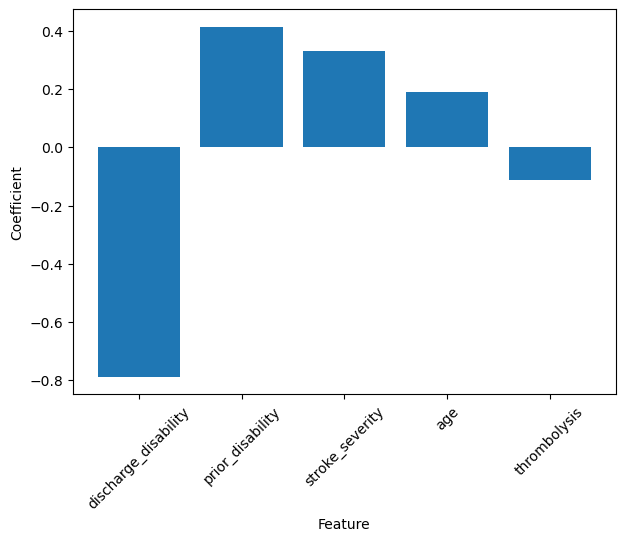


          Average MAE: 1.048413108
          Average RMSE: 1.378388463
          Average R-squared: 0.181646840
          Average adjusted R-squared: 0.181804322


In [18]:
# Standardised prior to regression
show_regression_results(reg_results)

#### Unstandardised results

**Interpreting the coefficients**

These variables were not standardised, so the coefficients are in their original units.  The coefficients represent the change in the outcome variable, for every one unit increase in the predictor, when the value of all other predictors is held constant. It shows that the relationship remains even when you control for other variables. It does not provide evidence for/against a causal relationship. The **direction of relationships is the same** as in the standardised regression.

Examples:
* **Thrombolysis** coefficient -0.28 means that, on average, if you had thrombolysis, you have a 0.28 improvement in mRS score between discharge and follow-up (association not causal, and of people who were followed up)
* **Discharge disability** coefficient -0.51 means having a one mRS score higher discharge disability associates with an improvement of 0.51 in mRS score between discharge and follow-up

**Interpreting the metrics**

These are the same as the metrics when unstandardised variables were used. Why is that?
* Is it because scikit learn standardise for you anyway? No, they don't do this, we checked the documentation and model code.
* Is it as this is a large dataset?
* Is it as there isn't huge variation in scales between the variables?

,coef,coef_abs
discharge_disability,-0.553723,0.553723
thrombolysis,-0.344529,0.344529
prior_disability,0.331157,0.331157
stroke_severity,0.058376,0.058376
age,0.014761,0.014761


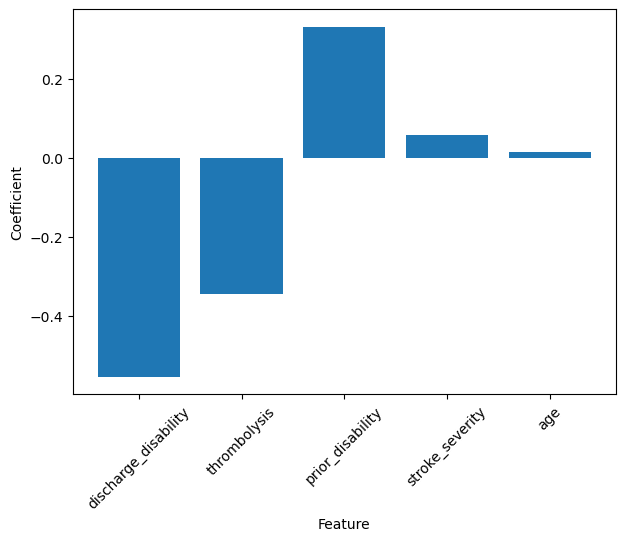


          Average MAE: 1.048413108
          Average RMSE: 1.378388463
          Average R-squared: 0.181646840
          Average adjusted R-squared: 0.181804322


In [19]:
# Did not standardise prior to regression
show_regression_results(reg_results_non_std)

### Assumptions

In [20]:
# Look at relationship between actual and predicted values
def test_linear(df):
    '''
    Test assumption of linearity.
    df is dataframe containing columns with predicted and actual
    values of the response variable.
    '''
    # Plot actual and predicted values
    fig, ax = plt.subplots(figsize=(4, 4))
    x = df['actual']
    y = df['pred']
    jittered_x = x + 0.1 * np.random.rand(len(x)) - 0.05
    jittered_y = y + 0.1 * np.random.rand(len(y)) - 0.05
    ax.scatter(jittered_x, jittered_y, s=0.2, alpha=0.5)
    ax.set_xlabel('Actual value')
    ax.set_ylabel('Predicted value')

    # Add diagonal line (based on overall min and max)
    line_coords = (df.min().min(), df.max().max())
    ax.plot(line_coords, line_coords, ls='--')

    plt.show()


def test_assumptions(X, reg_results):
    '''
    Tests assumptions of multiple linear regression
    X: dataframe where each column is a predictor variable
    reg_results: dictionary output by regression
    '''
    # Test for linear relationship between each predictor and outcome
    print('Linearity - look at relationship between each predictor and ' +
          'outcome - or look at\nrelationship between predicted and actual ' +
          'values (linearity indicated by even spread around diagnoal line)')

    # Look at linear relationship between each predictor and outcome
    fig, ax = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(15, 3))
    for i in np.arange(len(X.columns)):
        x = X.iloc[:, i]
        jittered_x = x + 0.1 * np.random.rand(len(x)) - 0.05
        jittered_y = y + 0.1 * np.random.rand(len(y)) - 0.05
        ax[i].scatter(jittered_x, jittered_y, s=0.2, alpha=0.5)
        ax[i].set_xlabel(X.columns[i])
        ax[i].set_ylabel('Change in disability from\ndischarge to followup')
    fig.tight_layout()
    plt.show()

    # Just plot from first train/test split
    test_linear(reg_results['residuals'][0])

    # Look at averages (if scatter not meaningful for linearity)
    fig, ax = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(15, 3))
    for i in np.arange(len(X.columns)):
        averages = X.groupby(y)[X.columns[i]].mean()
        averages.plot(marker='.', ax=ax[i])
        ax[i].set_xlabel('Change in mRS from discharge\n' +
                         'to 6-month follow-up')
        ax[i].set_ylabel(X.columns[i])
    fig.tight_layout()
    plt.show()

    # Test for normally distributed residuals
    print('Normally distributed residuals:')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(reg_results['residuals'][0]['residuals'],
            edgecolor='black', bins=20)
    plt.show()

    # Test for independent observations (just review manually)
    print('Independent observations: review manually\n')

    # Test for homoscedasticity
    print('Homoscedasticity - should be no patterns in distributions of' +
          'residuals - i.e. the size of error\nshould not relate to' +
          'the value of the outcome variable):')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(reg_results['residuals'][0].index,
               reg_results['residuals'][0].residuals,
               s=0.2, alpha=0.5)
    plt.show()

    # Test for multicolinearity
    print('Multicolinearity - if there is multicolinearity present, it ' +
          'will result in less precise estimates of individual\n' +
          'regression parameters (difficult to decide precisely what' +
          'each variable contributes) (unstable estimates, may vary\n' +
          'alot with addition or removal of data points) (larger' +
          'sample sizes can better handle multicolinearity)')
    display(round(X.corr(), 2))

    # Create figure object
    fig, ax = plt.subplots(figsize=(4, 4))

    # Set colours
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        '', ['red', 'white', 'blue'])
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

    # Create heatmap
    heatmap = ax.imshow(X.corr(), cmap=cmap, norm=norm)

    # Add legend for colours
    fig.colorbar(heatmap)

    # Show plot
    plt.show()

**Observations:**
* Linearity - not really. Can see most predictions are around -2 to +2 which is not suprising, as that is where the majority of points lie in reality.
* Normally distributed residuals - no (slight left skew)
* Independent observations - yes (as each row is different patient)
* Homoscedasticity - yes, appears so
* Multicolinearity - alright, max is 0.5, so doesn't appear to be problematic colinearity

Linearity - look at relationship between each predictor and outcome - or look at
relationship between predicted and actual values (linearity indicated by even spread around diagnoal line)


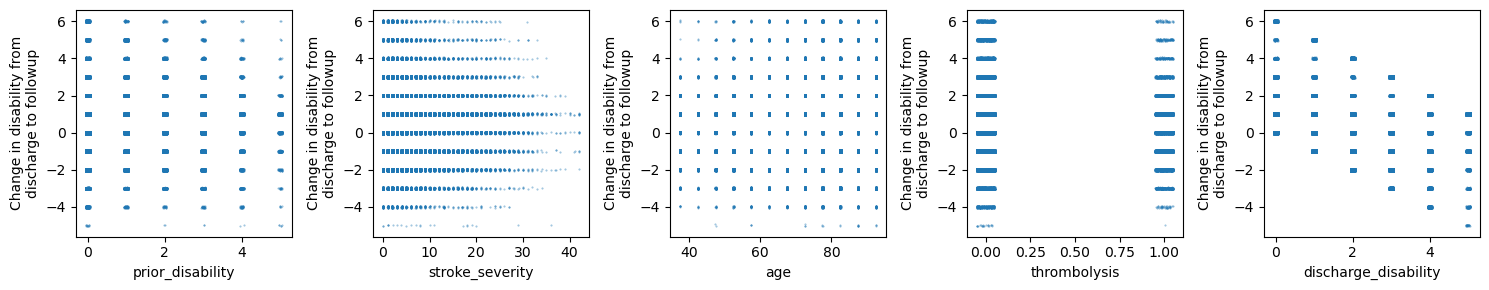

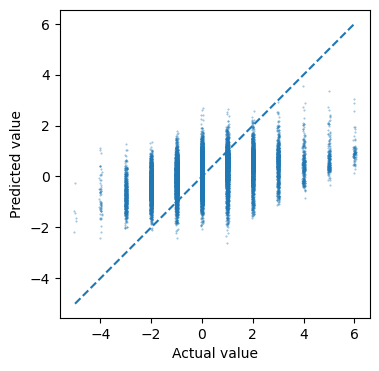

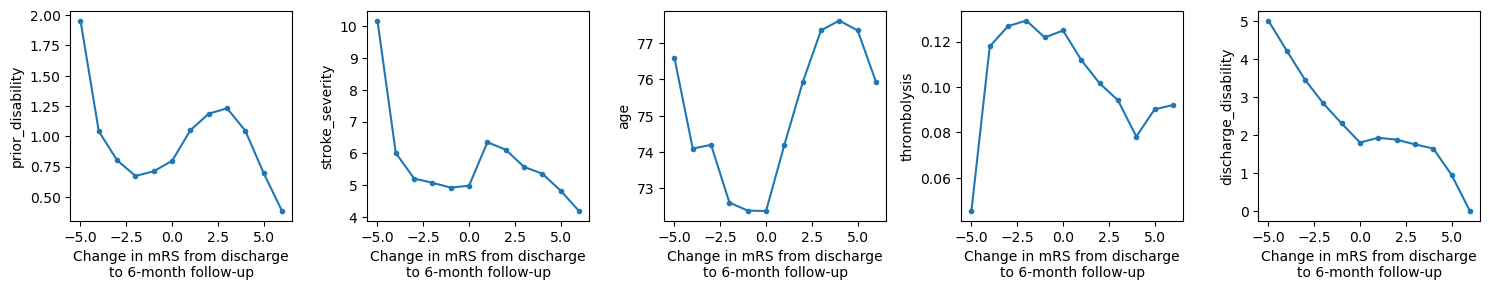

Normally distributed residuals:


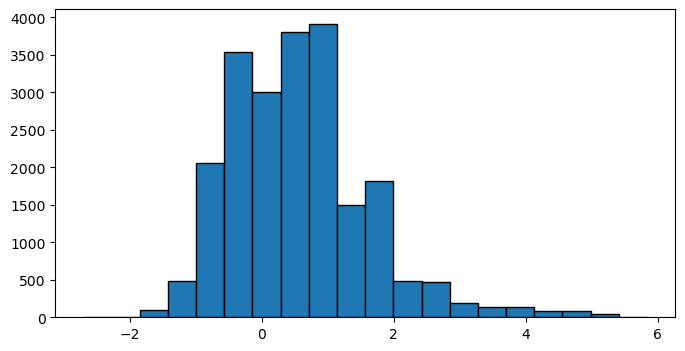

Independent observations: review manually

Homoscedasticity - should be no patterns in distributions ofresiduals - i.e. the size of error
should not relate tothe value of the outcome variable):


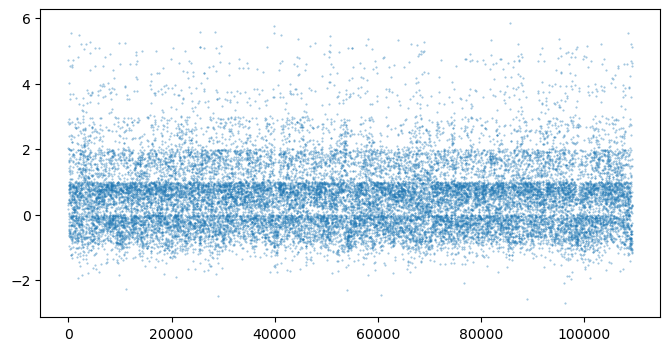

Multicolinearity - if there is multicolinearity present, it will result in less precise estimates of individual
regression parameters (difficult to decide precisely whateach variable contributes) (unstable estimates, may vary
alot with addition or removal of data points) (largersample sizes can better handle multicolinearity)


,prior_disability,stroke_severity,age,thrombolysis,discharge_disability
prior_disability,1.00,0.21,0.33,-0.08,0.51
stroke_severity,0.21,1.00,0.10,0.29,0.42
age,0.33,0.10,1.00,-0.04,0.29
thrombolysis,-0.08,0.29,-0.04,1.00,-0.02
discharge_disability,0.51,0.42,0.29,-0.02,1.00


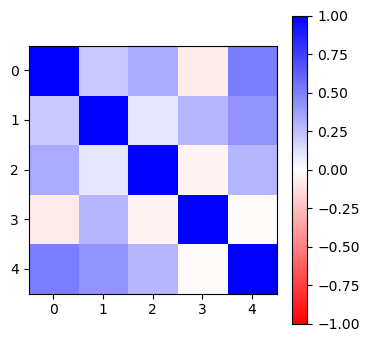

In [21]:
test_assumptions(X, reg_results)